In [2]:
pip install torchtext==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Successfully uninstalled torch-2.4.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.19.1+cu121 requires torch==2.4.1, but you have torch 1.11.0 which is incompatible.


In [3]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [9]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [10]:
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [11]:
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

In [12]:
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

Using device: cpu


In [14]:
class CNN(nn.Module):
    def __init__(self, vocab, k1, k2, n1, n2):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=True)
        embedding_dim = vocab.vectors.shape[1]

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_dim), bias=False)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_dim), bias=False)

        self.fc = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        # need to reorder the layers or else the model breaks, this debug was done by copilot
        embedded = embedded.permute(1, 0, 2).unsqueeze(1)

        # squeezes at the end  was a google collab auto suggestion (did not work prior but ths fixed it)
        conv1_out = F.relu(self.conv1(embedded)).squeeze(3)
        conv1_out = F.max_pool1d(conv1_out, conv1_out.shape[2]).squeeze(2)

        conv2_out = F.relu(self.conv2(embedded)).squeeze(3)
        conv2_out = F.max_pool1d(conv2_out, conv2_out.shape[2]).squeeze(2)

        concat_out = torch.cat((conv1_out, conv2_out), dim=1)

        output = self.fc(concat_out).squeeze(1)

        return output


In [15]:
def train_CNN_model(model, train_dataloader, validation_dataloader, epochs=50, lr=0.001):

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # loss function
    criterion = nn.BCEWithLogitsLoss()

    # stores for plotting
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_x, batch_y in train_dataloader:
            # line below was auto gen (not sure why but it needed this on collab)
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())

            # backward
            loss.backward()
            optimizer.step()

            # calc losses
            running_loss += loss.item()
            # the round function was also auto gen -> though there's some variability on stack over flow saying this works better
            preds = torch.round(torch.sigmoid(outputs))
            correct_predictions += (preds == batch_y).sum().item()
            total_predictions += batch_y.size(0)

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = correct_predictions / total_predictions

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # checking with val data
        val_loss, val_accuracy = evaluate_model(model, validation_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"[{epoch + 1}/{epochs}] Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # plots (generated using chatgpt)
    plt.figure(figsize=(12, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(np.arange(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(np.arange(1, epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # forward
            outputs = model(batch_x)

            # losses
            loss = criterion(outputs, batch_y.float())
            running_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct_predictions += (preds == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    val_loss = running_loss / len(dataloader)
    val_accuracy = correct_predictions / total_predictions

    return val_loss, val_accuracy


5.1 overfit test

[1/15] Train Loss: 1.2161, Train Accuracy: 0.5800 Validation Loss: 0.7011, Validation Accuracy: 0.5075
[2/15] Train Loss: 0.7417, Train Accuracy: 0.5200 Validation Loss: 0.6406, Validation Accuracy: 0.5856
[3/15] Train Loss: 0.5373, Train Accuracy: 0.8800 Validation Loss: 0.6123, Validation Accuracy: 0.6044
[4/15] Train Loss: 0.4410, Train Accuracy: 0.9400 Validation Loss: 0.5698, Validation Accuracy: 0.7069
[5/15] Train Loss: 0.3113, Train Accuracy: 1.0000 Validation Loss: 0.5318, Validation Accuracy: 0.7494
[6/15] Train Loss: 0.2067, Train Accuracy: 1.0000 Validation Loss: 0.4806, Validation Accuracy: 0.7987
[7/15] Train Loss: 0.1218, Train Accuracy: 1.0000 Validation Loss: 0.4434, Validation Accuracy: 0.8113
[8/15] Train Loss: 0.0706, Train Accuracy: 1.0000 Validation Loss: 0.4256, Validation Accuracy: 0.8044
[9/15] Train Loss: 0.0431, Train Accuracy: 1.0000 Validation Loss: 0.4164, Validation Accuracy: 0.8094
[10/15] Train Loss: 0.0288, Train Accuracy: 1.0000 Validation Loss: 0.411

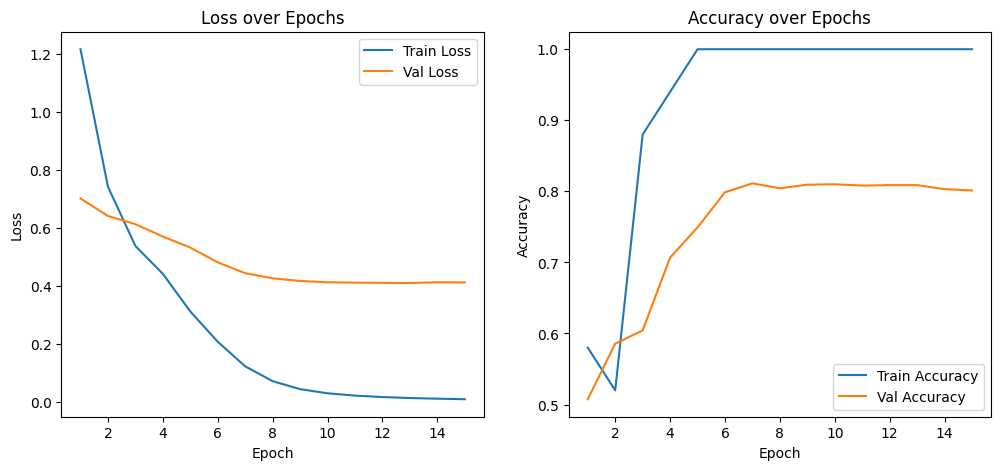

In [16]:
overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

model = CNN(glove, k1 = 2, n1 = 50, k2 =4, n2 = 50)

train_CNN_model(model, overfit_dataloader, validation_dataloader, epochs=15, lr=0.001)

5.2 training and tuning hyperparameters

In [17]:
# seed random
torch.manual_seed(0)

[1/15] Train Loss: 0.4164, Train Accuracy: 0.8416 Validation Loss: 0.3057, Validation Accuracy: 0.8762
[2/15] Train Loss: 0.2575, Train Accuracy: 0.9027 Validation Loss: 0.2687, Validation Accuracy: 0.8956
[3/15] Train Loss: 0.2163, Train Accuracy: 0.9198 Validation Loss: 0.2554, Validation Accuracy: 0.9038
[4/15] Train Loss: 0.1892, Train Accuracy: 0.9298 Validation Loss: 0.2498, Validation Accuracy: 0.9062
[5/15] Train Loss: 0.1678, Train Accuracy: 0.9425 Validation Loss: 0.2472, Validation Accuracy: 0.9081
[6/15] Train Loss: 0.1496, Train Accuracy: 0.9506 Validation Loss: 0.2459, Validation Accuracy: 0.9106
[7/15] Train Loss: 0.1334, Train Accuracy: 0.9578 Validation Loss: 0.2451, Validation Accuracy: 0.9100
[8/15] Train Loss: 0.1189, Train Accuracy: 0.9633 Validation Loss: 0.2466, Validation Accuracy: 0.9119
[9/15] Train Loss: 0.1058, Train Accuracy: 0.9694 Validation Loss: 0.2484, Validation Accuracy: 0.9131
[10/15] Train Loss: 0.0937, Train Accuracy: 0.9723 Validation Loss: 0.250

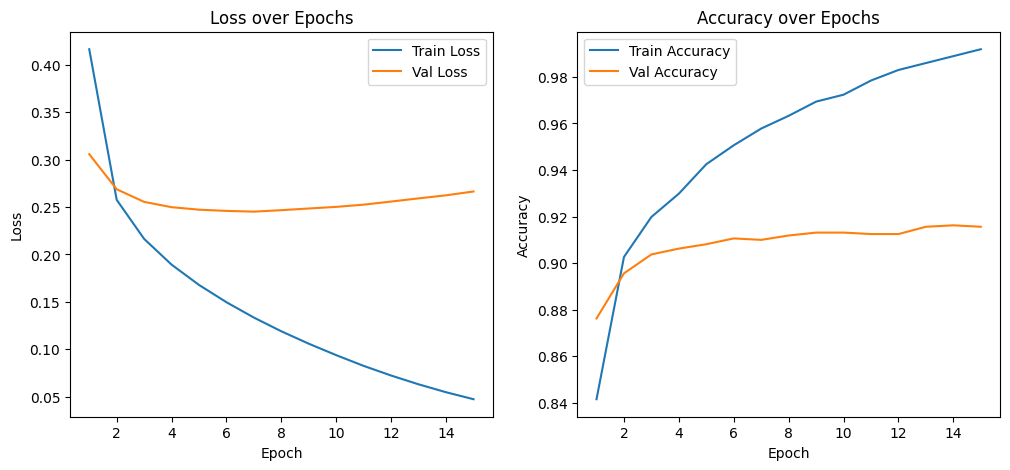

In [30]:
train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

model = CNN(glove, k1 = 2, n1 = 20, k2 =3, n2 = 25)
train_CNN_model(model, train_dataloader, validation_dataloader, epochs=15, lr=0.001)

rerun model with freeze false

In [33]:
class CNN_new(nn.Module):
    def __init__(self, vocab, k1, k2, n1, n2):
        super(CNN_new, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors, freeze=False)
        embedding_dim = vocab.vectors.shape[1]

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n1, kernel_size=(k1, embedding_dim), bias=False)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=n2, kernel_size=(k2, embedding_dim), bias=False)

        self.fc = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        # need to reorder the layers or else the model breaks, this debug was done by copilot
        embedded = embedded.permute(1, 0, 2).unsqueeze(1)

        # squeezes at the end  was a google collab auto suggestion (did not work prior but ths fixed it)
        conv1_out = F.relu(self.conv1(embedded)).squeeze(3)
        conv1_out = F.max_pool1d(conv1_out, conv1_out.shape[2]).squeeze(2)

        conv2_out = F.relu(self.conv2(embedded)).squeeze(3)
        conv2_out = F.max_pool1d(conv2_out, conv2_out.shape[2]).squeeze(2)

        concat_out = torch.cat((conv1_out, conv2_out), dim=1)

        output = self.fc(concat_out).squeeze(1)

        return output


[1/8] Train Loss: 0.4224, Train Accuracy: 0.8314 Validation Loss: 0.2881, Validation Accuracy: 0.8875
[2/8] Train Loss: 0.2091, Train Accuracy: 0.9219 Validation Loss: 0.2286, Validation Accuracy: 0.9094
[3/8] Train Loss: 0.1290, Train Accuracy: 0.9570 Validation Loss: 0.2088, Validation Accuracy: 0.9137
[4/8] Train Loss: 0.0768, Train Accuracy: 0.9781 Validation Loss: 0.2043, Validation Accuracy: 0.9144
[5/8] Train Loss: 0.0436, Train Accuracy: 0.9905 Validation Loss: 0.2086, Validation Accuracy: 0.9100
[6/8] Train Loss: 0.0238, Train Accuracy: 0.9961 Validation Loss: 0.2179, Validation Accuracy: 0.9119
[7/8] Train Loss: 0.0125, Train Accuracy: 0.9986 Validation Loss: 0.2335, Validation Accuracy: 0.9125
[8/8] Train Loss: 0.0067, Train Accuracy: 0.9997 Validation Loss: 0.2511, Validation Accuracy: 0.9150


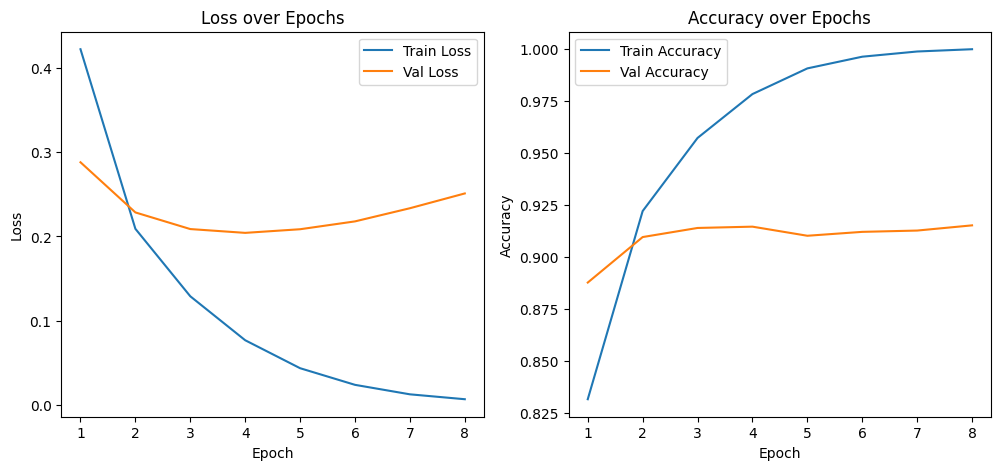

In [37]:
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

model = CNN_new(glove, k1 = 2, n1 = 20, k2 =3, n2 = 25)
train_CNN_model(model, train_dataloader, validation_dataloader, epochs=8, lr=0.001)

In [38]:
torch.save(model.state_dict(), 'CNN.pt')

5.3 extract meaning from from kernels

In [44]:
def print_closest_cosine_words(vec, n=5):
    dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0), dim=1)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: -x[1])
    for idx, similarity in lst[1:n+1]:
        print(glove.itos[idx], "\t%5.2f" % similarity)

In [45]:
kernel = model.conv1.weight[0].detach().cpu().numpy()[0][0]

print(kernel.shape)
print(kernel)


(100,)
[-0.06964432 -0.0616744   0.10482941  0.03277312 -0.05867295 -0.06038985
  0.07468756  0.02202473  0.1465744   0.01808246  0.05967922  0.03487106
 -0.01999081 -0.08976964 -0.16507153 -0.0723631   0.00226657 -0.04594429
  0.07751081  0.09702523 -0.07779111  0.07178763 -0.11408633  0.00403389
 -0.0077074   0.03920931 -0.05815793  0.01541727 -0.10272021 -0.06555934
  0.08007558 -0.0216347  -0.05377898 -0.1118369   0.00234584  0.16228351
  0.01323613 -0.0889594  -0.12231652 -0.09174594  0.09474733  0.08706487
 -0.03868899 -0.09296292 -0.04094939 -0.07584354  0.07064354 -0.0685123
 -0.10507333 -0.03023756  0.05096093 -0.02986735 -0.06305639  0.04844692
  0.02888637 -0.02088518  0.14938262 -0.03857983  0.06125156 -0.09225655
 -0.05450882 -0.07568328  0.00739169  0.04498315  0.00084434 -0.13934276
 -0.06302547  0.02548753 -0.03344771 -0.04969555  0.04744611 -0.06560668
  0.22596726 -0.01525916  0.10267    -0.14738262 -0.09725171 -0.0796715
 -0.01296116  0.17575161 -0.08032271 -0.017079

In [47]:
print_closest_cosine_words(torch.tensor(kernel), n=5)

inadvisable 	 0.50
debatable 	 0.50
advantageous 	 0.49
preferable 	 0.48
pourable 	 0.48


In [55]:
# used chatgpt to modify the print so it's nicer in console output
def print_closest_cosine_words(vec, n=5):
    dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0), dim=1)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: -x[1])
    similar_words = [glove.itos[idx] for idx, similarity in lst[1:n+1]]
    print(f"{' '.join(similar_words)}")


for i in range(model.conv1.weight.shape[0]):
  print(f"Kernel {i+1}:")
  kernel = model.conv1.weight[i].detach().cpu().numpy()[0][0]
  print_closest_cosine_words(torch.tensor(kernel), n=5)

Kernel 1:
inadvisable debatable advantageous preferable pourable
Kernel 2:
pursuits unsuccessful housemates in-laws housemate
Kernel 3:
roommates tormentors labelmates co-worker dorm
Kernel 4:
17-inch 556-1927 tohr problematic inbio
Kernel 5:
sweeter troublingly trifle icier impressively
Kernel 6:
l&br nsdap forty-eighth trinamul lyoness
Kernel 7:
manchevski avy brisseau padmarajan tresnjak
Kernel 8:
via ; vols. travels originating
Kernel 9:
te part-time apprentices privateer merchantman
Kernel 10:
recruited bramshill pre-med pre-law raided
Kernel 11:
decent puny pleasing classier enjoyable
Kernel 12:
life-affirming whiny pretentious inelegant nauseating
Kernel 13:
tormentors buhera hideout loughton lairs
Kernel 14:
kwin ahth pales tehl chehr
Kernel 15:
underwhelming unshowy rollicking chintzy captivating
Kernel 16:
brothel poker casino millionaire bookie
Kernel 17:
pyrams in-laws adoptive her half-sisters
Kernel 18:
art-house writer-director huppert auteur 14-screen
Kernel 19:
oscar-n